# MarlimR3D Model using `emg3d`

### Note regarding runtime

The following environment variables were set before starting Jupyter:
```
export OMP_NUM_THREADS=1
export MKL_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
```
This ensures that our code runs only on one thread. CPU-time is therefore the same as walltime (or even a tiny fraction smaller).

In [1]:
import emg3d
import discretize
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
%load_ext memory_profiler

In [2]:
%matplotlib notebook

## Load model

In [3]:
data = np.load('../marlim_comp.npz')  #  or 'marlim_orig.npz'
tres_h = data['res_h']
tres_v = data['res_v']

# We have to add an air layer
hz = np.r_[data['hz'], 20]

mesh_c = discretize.TensorMesh(
    [data['hx'], data['hy'], hz], x0=data['x0'])

# Add air resistivity
res_h_c = 1e8*np.ones(mesh_c.vnC)
res_v_c = 1e8*np.ones(mesh_c.vnC)
res_h_c[:, :, :-1] = tres_h
res_v_c[:, :, :-1] = tres_v
del data, tres_h, tres_v

mesh_c

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

<IPython.core.display.Javascript object>


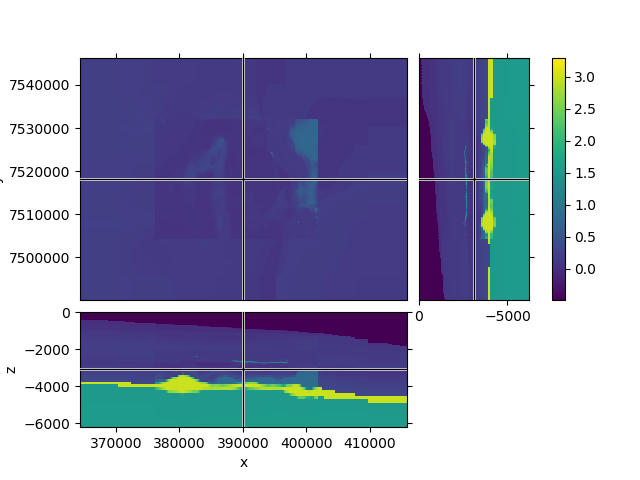

In [4]:
# QC resistivities
mesh_c.plot_3d_slicer(np.log10(res_h_c), clim=[np.log10(0.32), np.log10(2000)])

# QC anisotropies
#mesh_c.plot_3d_slicer(np.sqrt(res_v_c/res_h_c))

## Load survey

In [5]:
ds = xr.load_dataset('../marlim_survey.nc', engine='h5netcdf')
# data = xr.load_dataset('../marlim_data.nc', engine='h5netcdf')

### Extract required info

In [6]:
# Use reciprocity: rec becomes src
src = [ds.rec_x, ds.rec_y, ds.rec_z,
       ds.rec_theta, ds.rec_dip]

# Use reciprocity: src becomes rec
rec_x = ds.data_il_re.src_x
rec_y_il = ds.data_il_re.src_y
rec_z_il = ds.data_il_re.src_z

# Ensure same coordinates
print(np.allclose(rec_x, ds.data_bs_re.src_x))

rec_y_bs = ds.data_bs_re.src_y
rec_z_bs = ds.data_bs_re.src_z

# Frequency
freqs = ds.freqs.values

True


## Computation mesh

In [7]:
# Get cell widths and origin in each direction
inp = {'freq': freqs.min(), 'max_domain': 50000}
minres = res_h_c.min()
maxres = res_v_c[res_v_c<1e7].max()

xx, x0 = emg3d.utils.get_hx_h0(
    res=[minres, maxres], fixed=src[0], domain=[src[0]-5000, src[0]+5000],
    min_width=mesh_c.hx[0], **inp)

yy, y0 = emg3d.utils.get_hx_h0(
    res=[minres, maxres], fixed=src[1], domain=[src[1]-2000, src[1]+1000],
    min_width=mesh_c.hy[0], **inp)

zz, z0 = emg3d.utils.get_hx_h0(
    res=[minres, 100, maxres], domain=[-2000, 0],
    min_width=mesh_c.hz[0], **inp)

# Create a TensorMesh instance.
mesh = discretize.TensorMesh([xx, yy, zz], x0=[x0, y0, z0])
mesh

   Skin depth (m/l-r)  [m] : 805 / 56616
   Survey domain       [m] : 385275 - 395275
   Calculation domain  [m] : 340275 - 440275
   Final extent        [m] : 339791 - 440759
   Min/max cell width  [m] : 100 / 100 / 13553
   Alpha survey/calc       : 1.000 / 1.420
   Number of cells (s/c/r) : 128 (100/28/0)

   Skin depth (m/l-r)  [m] : 805 / 56616
   Survey domain       [m] : 7515812 - 7518812
   Calculation domain  [m] : 7467812 - 7567812
   Final extent        [m] : 7464832 - 7569792
   Min/max cell width  [m] : 100 / 100 / 12749
   Alpha survey/calc       : 1.000 / 1.330
   Number of cells (s/c/r) : 64 (30/34/0)

   Skin depth (m/l/r)  [m] : 805 / 14235 / 56616
   Survey domain       [m] : -2000 - 0
   Calculation domain  [m] : -50000 - 50000
   Final extent        [m] : -54798 - 65515
   Min/max cell width  [m] : 20 / 20 / 12696
   Alpha survey/calc       : 1.000 / 1.240
   Number of cells (s/c/r) : 160 (101/58/1)



TensorMesh: 1,310,720 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128    339,790.90    440,759.10    100.00 13,553.04    1.42
   y     64  7,464,832.49  7,569,791.51    100.00 12,749.05    1.33
   z    160    -54,798.33     65,514.73     20.00 12,696.40    1.24

In [8]:
# Interpolate to new mesh
res_h = emg3d.utils.grid2grid(mesh_c, res_h_c, mesh, 'volume', log=True)
res_v = emg3d.utils.grid2grid(mesh_c, res_v_c, mesh, 'volume', log=True)

# Create model instance
model = emg3d.utils.Model(mesh, res_x=res_h, res_z=res_v)

# `emg3d` computation

In [13]:
# Pre-allocate results-array
egd = np.zeros((2, rec_x.size, 6, 6), dtype=complex)
    
max_mem = 0
tot_time = 0
for ii, freq in enumerate(freqs):
    print(f" === Frequency {ii}/{freqs.size} :: {freq} Hz ===")
    # Source field
    sfield = emg3d.utils.get_source_field(mesh, src, freq, strength=0)
   
    mem = %memit -o efield, info = emg3d.solve(mesh, model, sfield, sslsolver=True, linerelaxation=True, verb=-1, return_info=True)
    tot_time += info['time']
    ram = mem.mem_usage[0] - mem.baseline
    if ram > max_mem:
        max_mem = ram    
    
    # Extract (interpolate) Ex-field at receiver locations from the emg3d result.
    for i, rec in enumerate(zip([rec_y_il, rec_y_bs], [rec_z_il, rec_z_bs])):
        egd[i, :, ii, 0] = emg3d.utils.get_receiver(mesh, efield.fx, (rec_x, rec[0], rec[1]))
        egd[i, :, ii, 1] = emg3d.utils.get_receiver(mesh, efield.fy, (rec_x, rec[0], rec[1]))
        egd[i, :, ii, 2] = emg3d.utils.get_receiver(mesh, efield.fz, (rec_x, rec[0], rec[1]))
        
time = f"{tot_time:.0f} s"
ram = f"{max_mem:.0f} MiB"
print(f"time: {time}; memory usage: {ram}")

 === Frequency 0/6 :: 0.125 Hz ===
:: emg3d :: 9.7e-07; 6(34); 0:08:39; CONVERGED
peak memory: 3193.07 MiB, increment: 781.38 MiB
 === Frequency 1/6 :: 0.25 Hz ===
:: emg3d :: 7.7e-07; 4(20); 0:05:01; CONVERGED
peak memory: 3254.56 MiB, increment: 713.11 MiB
 === Frequency 2/6 :: 0.5 Hz ===
:: emg3d :: 7.2e-07; 3(14); 0:03:29; CONVERGED
peak memory: 3254.54 MiB, increment: 718.44 MiB
 === Frequency 3/6 :: 0.75 Hz ===
:: emg3d :: 5.7e-07; 2(11); 0:02:44; CONVERGED
peak memory: 3254.65 MiB, increment: 718.55 MiB
 === Frequency 4/6 :: 1.0 Hz ===
:: emg3d :: 8.6e-07; 2(8); 0:02:01; CONVERGED
peak memory: 3254.64 MiB, increment: 718.46 MiB
 === Frequency 5/6 :: 1.25 Hz ===
:: emg3d :: 9.3e-07; 2(7); 0:01:47; CONVERGED
peak memory: 3254.63 MiB, increment: 718.44 MiB
time: 1421 s; memory usage: 781 MiB


In [14]:
# Save the three lines
ds.data_il_re.data = egd[0, :, :, :].real  # Inline RE
ds.data_il_im.data = egd[0, :, :, :].imag  # Inline IM

ds.data_bs_re.data = egd[1, :, :, :].real  # Broadside RE
ds.data_bs_im.data = egd[1, :, :, :].imag  # Broadside IM

# Add info
ds.attrs['runtime'] = time
ds.attrs['cputime'] = time  # Run on 1 thread, so cputime <~ runtime
ds.attrs['nthreads'] = 1
ds.attrs['maxram'] = ram
ds.attrs['ncells'] = f"({mesh.nCx} x {mesh.nCy} x {mesh.nCz}) - {mesh.nC}"
ds.attrs['nnodes'] = 'N/A'
ds.attrs['ndof'] = 'N/A'
ds.attrs['extent'] = (f"x = {mesh.vectorNx[0]:.1f}-{mesh.vectorNx[-1]:.1f}; " # Total mesh extent
                      f"y = {mesh.vectorNy[0]:.1f}-{mesh.vectorNy[-1]:.1f}; "
                      f"z = {mesh.vectorNz[0]:.1f}-{mesh.vectorNz[-1]:.1f}")
ds.attrs['min_cwidth'] = f"({mesh.hx.min():.1f} x {mesh.hy.min():.1f} x {mesh.hz.min():.1f})"
ds.attrs['max_cwidth'] = f"({mesh.hx.max():.1f} x {mesh.hy.max():.1f} x {mesh.hz.max():.1f})"
ds.attrs['nedges'] = 'N/A'
ds.attrs['machine'] = "Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04"
ds.attrs['version'] = f"emg3d v{emg3d.__version__}"
ds.attrs['date'] = datetime.today().isoformat()

# ADD A NOTE that this is preliminary
ds.attrs['NOTE'] = 'Preliminary results, not final'

# Save it under <{model}_{code}.nc>
ds.to_netcdf(f"../results/marlim_emg3d.nc", engine='h5netcdf')
ds

<xarray.Dataset>
Dimensions:     (components: 6, freqs: 6, src_x: 204)
Coordinates:
  * components  (components) object 'Ex' 'Ey' 'Ez' 'Hx' 'Hy' 'Hz'
  * freqs       (freqs) float32 0.125 0.25 0.5 0.75 1.0 1.25
  * src_x       (src_x) float32 379375.0 379475.0 379575.0 ... 401075.0 401175.0
Data variables:
    data_bs_im  (src_x, freqs, components) float64 -7.117e-15 -1.809e-15 ... 0.0
    data_bs_re  (src_x, freqs, components) float64 -1.005e-14 -1.623e-15 ... 0.0
    data_il_im  (src_x, freqs, components) float64 -7.735e-15 -1.633e-16 ... 0.0
    data_il_re  (src_x, freqs, components) float64 -1.034e-14 6.399e-17 ... 0.0
Attributes:
    cputime:     1421 s
    date:        2020-03-20T18:34:42.264088
    extent:      x = 339790.9-440759.1; y = 7464832.5-7569791.5; z = -54798.3...
    machine:     Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
    max_cwidth:  (13553.0 x 12749.1 x 12696.4)
    maxram:      781 MiB
    min_cwidth:  (100.0 x 100.0 x 20.0)
    ncells:      (128 x 64 x 160) - 1310720
    ndof:        N/A
    nnodes:      N/A
    nthreads:    1
    rec_dip:     0.0
    rec_theta:   0.0
    rec_x:       390275.0
    rec_y:       7517812.0
    rec_z:       -849.7838
    runtime:     1421 s
    src_dip:     0.0
    src_theta:   0.0
    strength:    1.0
    version:     emg3d v0.9.3
    nedges:      N/A
    NOTE:        Preliminary results, not final

## Figure 4 from Correa and Menezes (2019), but noise-free data

In [15]:
data = xr.load_dataset('../marlim_data.nc', engine='h5netcdf')

<IPython.core.display.Javascript object>


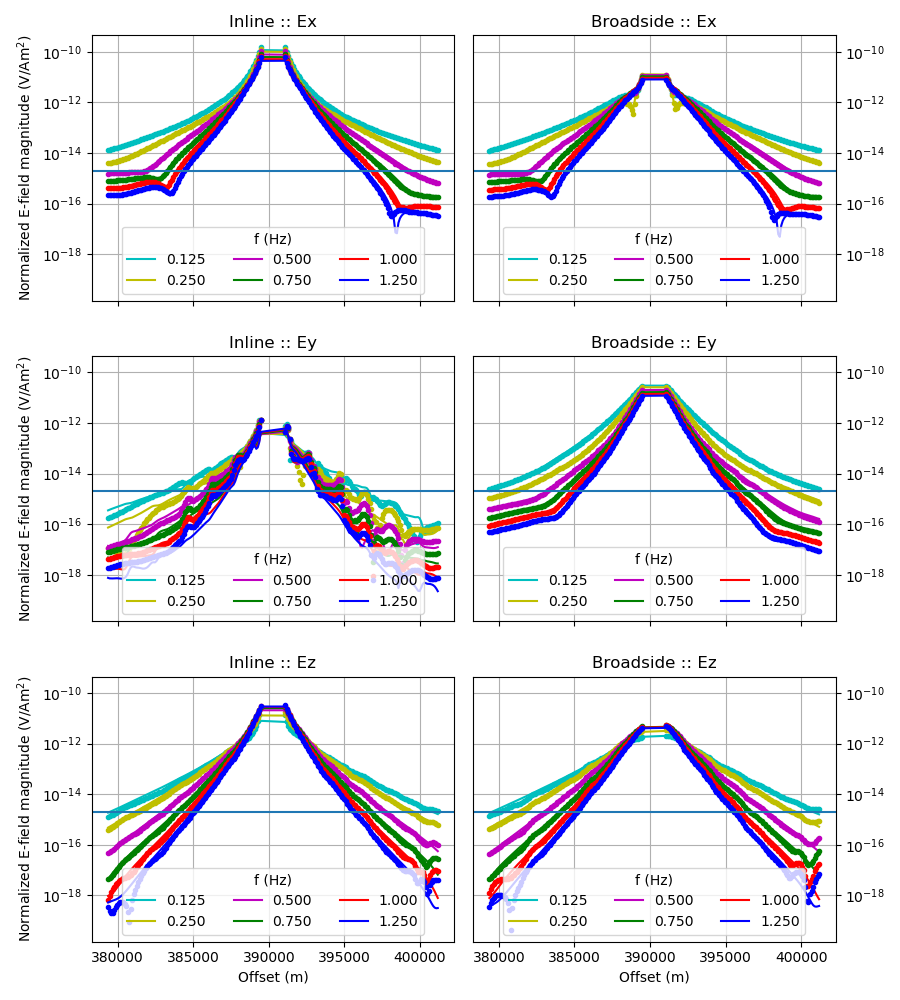

In [19]:
# Line styles
ls = ['co', 'ys', 'm*', 'gd', 'rv', 'b^']

fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Take absolute value
    tdat = np.abs(getattr(data, datname+'_re') + 1j*getattr(data, datname+'_im'))

    # Loop over components Ex, Ey, Ez
    for ii, comp in enumerate(data.components.values[:3]):

        plt.sca(axs[ii, iii])
        plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

        # Loop over frequencies
        for i, freq in enumerate(data.freqs.values):

            # Plot this component/frequency
            plt.plot(rec_x, tdat[:, i, ii], ls[i][0]+'-', label=f"{freq:4.3f}")
            plt.plot(rec_x, abs(egd[iii, :, i, ii]), ls[i][0]+'.')
            #plt.plot(rec_x, abs(tdat[:, i, ii]-abs(egd[iii, :, i, ii])), ls[i][0]+'-')

        plt.axhline(2e-15)
        plt.legend(title='f (Hz)', loc='lower center', ncol=3)
        plt.grid('on')
        plt.yscale('log')
        
        if ii == 2:
            plt.xlabel('Offset (m)')
        if iii == 0:
            plt.ylabel('Normalized E-field magnitude (V/Am$^2$)')
        else:
            axs[ii, iii].yaxis.set_ticks_position('right')
            axs[ii, iii].yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

In [17]:
emg3d.Report([discretize, xr])

--------------------------------------------------------------------------------
  Date: Fri Mar 20 18:34:43 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

        discretize : 0.4.10
            xarray : 0.15.0
             numpy : 1.15.4
             scipy : 1.4.1
             numba : 0.48.0
             emg3d : 0.9.3
           IPython : 7.13.0
        matplotlib : 3.1.3
--------------------------------------------------------------------------------